# Tests of the event rejection (ER) algorithm for four-jet event selections

In [ ]:
from h5py import File
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm
import random
import itertools as it
import time
import joblib

In [ ]:
#Opening the HDF5 File
#input_file = "../output.h5"
#input_file = "../data22_13p6TeV.00440499.physics_EnhancedBias.h5"
#input_file = "../EBdata.h5"
input_file = "../hh4b.h5"
#input_file = "../jz0.h5"
#input_file = "../jz1.h5"
#input_file = "../jz2.h5"
#input_file = "../jz3.h5"
#input_file = "../jz4.h5"
#input_file = "../jz5.h5"

data = File(input_file, 'r')
print("List of available datasets: " + str(list(data.keys())))

In [ ]:
#Accessing the 'Jets' Dataset
jets = data['jets']
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))
print("The shape of the dataset is: " + str(jets.shape))

In [ ]:
print("The number of jets in the sample is: " + str(len(jets)))
print("The number of jets in the sample with pT < 20 GeV is: " + str(len(jets[jets["pt"] < 20])))
print("The number of jets in the sample with eta > 2.5 GeV is: " + str(len(jets[jets["eta"] > 2.5])))

In [ ]:
#Getting the events in our sample
uniques = np.unique(jets["eventNumber"])
print("The number of events in our sample is: " + str(len(uniques)))
print("The events_ID array looks like: " + str(uniques))

In [1]:
#Getting a subset the events in our sample
sub_uniques = uniques[:999]
print("The number of events in our subset is: " + str(len(uniques)))
print("The events_ID array of the subset looks like: " + str(uniques))

NameError: name 'uniques' is not defined

In [36]:
%%time
# Getting an array of the jet multiplicities in the sample
jet_multiplicities = []
for i in uniques:
    jet_multiplicities.append(len(jets[jets["eventNumber"] == i]))

CPU times: user 43.3 s, sys: 1.06 s, total: 44.3 s
Wall time: 45 s


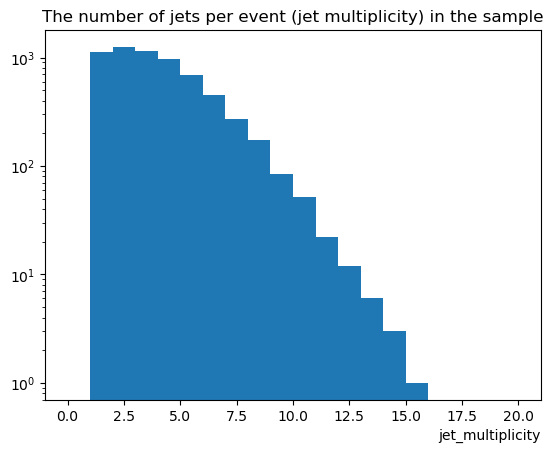

In [37]:
# Plotting the jet multiplicities in the sample
plt.hist(jet_multiplicities, bins = 20, range=(0,20))
plt.yscale('log')
plt.xlabel("jet_multiplicity", loc='right')
plt.title('The number of jets per event (jet multiplicity) in the sample')
plt.show()

In [8]:
%%time
# Getting an array of the leading jet pT's per event in the sample
leading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet['pt'])
    leading_pT.append(max(pTs))

CPU times: user 40.2 s, sys: 483 ms, total: 40.6 s
Wall time: 40.7 s


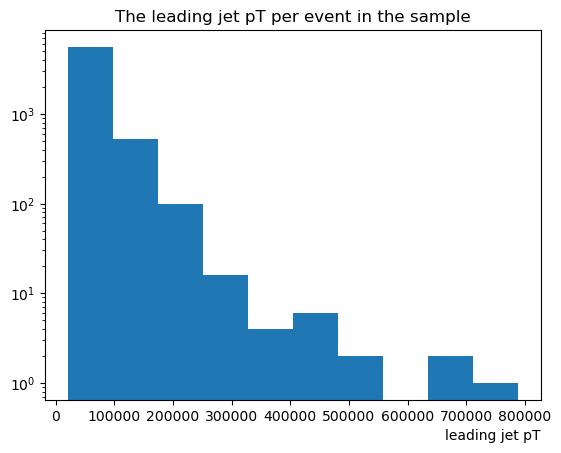

In [9]:
# Plotting the leading jet pT's per event in the sample
plt.hist(leading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("leading jet pT", loc='right')
plt.title('The leading jet pT per event in the sample')
plt.show()

In [10]:
%%time
# Getting an array of the sub-leading jet pT's per event in the sample
subleading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    if len(pTs) > 1: 
        subleading_pT.append(sorted(pTs)[-2])

CPU times: user 40 s, sys: 531 ms, total: 40.6 s
Wall time: 40.6 s


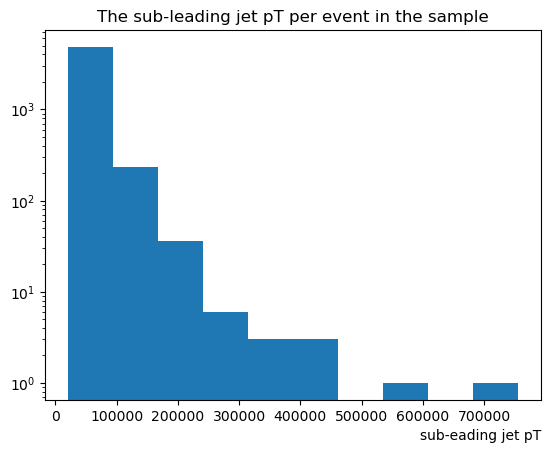

In [11]:
# Plotting the sub-leading jet pT's per event in the sample
plt.hist(subleading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("sub-eading jet pT", loc='right')
plt.title('The sub-leading jet pT per event in the sample')
plt.show()

In [38]:
%%time

#Filtering the four-or-more jet events
fom_events = []
counter = 0



for id in uniques:
    if len(jets[jets["eventNumber"] == id]) >= 4:
        fom_events.append(id)
        counter +=1
    #if counter == 1000:
        #break
"""
for id in uniques:
    event_jets = jets[jets["eventNumber"] == id]
    bjets = event_jets[event_jets["HadronConeExclTruthLabelID"] == 5]
    if len(event_jets) >= 4 & len(bjets) >= 4:
        fom_events.append(id)
        counter +=1
    if counter == 100:
        break
"""
print("The number of events that have four or more (fom) selected jets is: " + str(len(fom_events)))

The number of events that have four or more (fom) selected jets is: 2727
CPU times: user 43.4 s, sys: 1.18 s, total: 44.6 s
Wall time: 44.7 s


In [39]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event NUMERICALLY

def get_max_log_likelihood_num(event_id,jets):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    z = np.arange(-5*50, 5*50, 0.1)

    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        log_total_likelihood = -4 * np.log(np.sqrt(2*np.pi))
            
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) *50
            #likelihood = (2*np.pi)**(-1/2) * (sigma)**(-1) * np.exp( -1 * (z - mu)**2 * (2 * sigma^2)**(-1) )
            log_total_likelihood -= ( np.log(sigma) + (z - mu)**2 * (2 * sigma**(2))**(-1) )
    
        mlpl_array.append(max(log_total_likelihood))
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood

In [40]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event ANALYTICALLY

def get_max_log_likelihood_an(event_id,jets,comb_num,num_highest_pt=555555):
    event_jets = jets[jets["eventNumber"] == event_id]
    
    if num_highest_pt != 555555:
        if len(event_jets) > num_highest_pt:
            event_jets = event_jets[(-event_jets['pt']).argsort()[:num_highest_pt]]
    
    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, comb_num):
        combinations.append(combination)

    for comb in combinations:
        num = 0
        denom = 0
        second_term = 0
        third_term = 0
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            num += (mu) / (sigma**2)
            denom += 1 / (sigma**2)
            second_term -= np.log(sigma)
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            third_term -= ((num / denom) - mu)**2 / (2*sigma**2) 
            
        mlpl_array.append(-4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term)
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood


In [41]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event ANALYTICALLY

def get_max_log_likelihood_an_hh4b(event_id,jets,comb_num,num_highest_pt=555555):
    event_jets = jets[jets["eventNumber"] == event_id]

    if num_highest_pt != 555555:
        if len(event_jets) > num_highest_pt:
            event_jets = event_jets[(-event_jets['pt']).argsort()[:num_highest_pt]]
    
    combinations = []

    for combination in it.combinations(event_jets, comb_num):
        combinations.append(combination)

    mlpl = -999999999999
    highest_comb = np.empty

    for comb in combinations:
        num = 0
        denom = 0
        second_term = 0
        third_term = 0
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            num += (mu) / (sigma**2)
            denom += 1 / (sigma**2)
            second_term -= np.log(sigma)
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            third_term -= ((num / denom) - mu)**2 / (2*sigma**2) 
            
        if -4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term > mlpl:
            mlpl = -4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term
            highest_comb = comb
            
    num_bjets_chosen = 0
    for jet in highest_comb:
       if jet['HadronConeExclTruthLabelID'] == 5:
           num_bjets_chosen += 1
    
    max_log_likelihood = mlpl
    
    return max_log_likelihood, num_bjets_chosen

In [42]:
len(jets[jets["eventNumber"] == fom_events[0]])

8

In [100]:
%%time
range = np.arange(0,500,1)
for i in range:
    get_max_log_likelihood_an(fom_events[0],jets,4)

CPU times: user 5.24 s, sys: 99.5 ms, total: 5.34 s
Wall time: 5.41 s


In [101]:
%%time
range = np.arange(0,500,1)
for i in range:
    get_max_log_likelihood_an(fom_events[3],jets,3)

CPU times: user 3.52 s, sys: 95.9 ms, total: 3.61 s
Wall time: 3.61 s


In [102]:
%%time
range = np.arange(0,500,1)
for i in range:
    get_max_log_likelihood_an(fom_events[3],jets,3,5)

CPU times: user 3.6 s, sys: 83.8 ms, total: 3.68 s
Wall time: 3.7 s


In [103]:
%%time
range = np.arange(0,500,1)
for i in range:
    get_max_log_likelihood_an(fom_events[3],jets,2)

CPU times: user 3.56 s, sys: 108 ms, total: 3.67 s
Wall time: 3.68 s


In [17]:
def get_max_log_likelihood_dist(string, num=999999999999999):
    start = time.time()
    data = File(string, 'r')
    jets = data['jets']
    uniques = np.unique(jets["eventNumber"])
    
    print("The number of jets in the sample is: " + str(len(jets)))
    print("The number of jets in the sample with pT < 20 GeV is: " + str(len(jets[jets["pt"] < 20])))
    print("The number of jets in the sample with eta > 2.5 GeV is: " + str(len(jets[jets["eta"] > 2.5])))
    print("The number of events in our sample is: " + str(len(uniques)))
    
    max_log_likelihood_list = []
    no_of_processed_events = num
    counter = 0

    for id in uniques:
        if len(jets[jets["eventNumber"] == id]) >= 4:
            max_log_likelihood_list.append(get_max_log_likelihood_an(id,jets))
            counter +=1
        if counter == no_of_processed_events:
            break

    if counter == no_of_processed_events:
        print("The provided number of four or more jet events in the sample was run over and it is: " + str(num))
    if counter != no_of_processed_events:
        print("The number of four or more jet events in the sample is: " + str(counter))
        print("The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.")
    end = time.time()
    print("The time of execution of the (get_max_log_likelihood_dist) function is :", ((end-start) / 60) , "min")

    return max_log_likelihood_list

def plot_distribution(max_log_likelihood_list):
    plt.hist(max_log_likelihood_list, bins = 500)
    plt.yscale("log")
    plt.xlabel("MLPL", loc='right')
    plt.title('Distribution of the discriminant variable (MLPL)')
    plt.show()

In [ ]:
test_dist = get_max_log_likelihood_dist(input_file, 4, 5, 5)
plot_distribution(test_dist)
joblib.dump(test_dist, 'test_dist.sav')

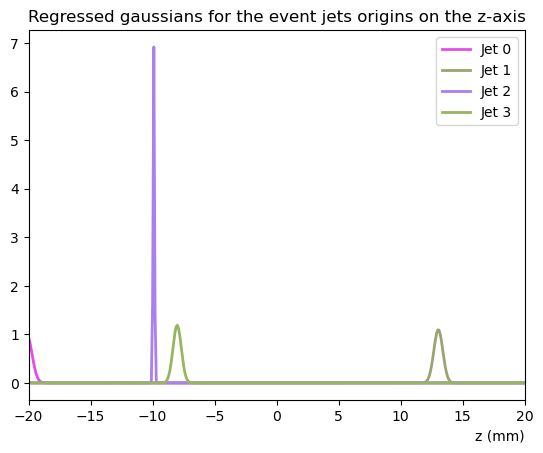

MLLP for this event is: -14.385031041142366


In [18]:
# Visualizing the jets in one event
index = 3

event_id = fom_events[index]
event_jets = jets[jets["eventNumber"] == event_id]
num_jets = len(event_jets)

#Generating random colors for  the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(num_jets)]
ic = 0      #color counter
x = np.arange(-4*50, 4*50, 0.1)

for i in range(num_jets):
    #plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"], np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"]*50, np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    ic = ic + 1    
plt.xlabel("z (mm)", loc='right')
plt.title('Regressed gaussians for the event jets origins on the z-axis')
plt.xlim([-2*10, 2*10])
plt.legend()
plt.show()
#plt.cla()

print("MLLP for this event is: " + str(get_max_log_likelihood_an(fom_events[index],jets, 4)))

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

## Doing the leading pT distribution the weighted sum of the JZ slices =

In [25]:
norm_jz0 = 50000 / len(leading_pT_jz0)
norm_jz1 = 50000 / len(leading_pT_jz1)
norm_jz2 = 50000 / len(leading_pT_jz2)
norm_jz3 = 50000 / len(leading_pT_jz3)
norm_jz4 = 50000 / len(leading_pT_jz4)
norm_jz5 = 50000 / len(leading_pT_jz5)

In [26]:
leading_pT_jz0 = joblib.load("./leading_pt_dist/leading_pT_jz0_dist.sav")
leading_pT_jz1 = joblib.load("./leading_pt_dist/leading_pT_jz1_dist.sav")
leading_pT_jz2 = joblib.load("./leading_pt_dist/leading_pT_jz2_dist.sav")
leading_pT_jz3 = joblib.load("./leading_pt_dist/leading_pT_jz3_dist.sav")
leading_pT_jz4 = joblib.load("./leading_pt_dist/leading_pT_jz4_dist.sav")
leading_pT_jz5 = joblib.load("./leading_pt_dist/leading_pT_jz5_dist.sav")

In [27]:
weights_jz0 = np.full_like(leading_pT_jz0,norm_jz0 * 0.7651165653000001)
weights_jz1 = np.full_like(leading_pT_jz1,norm_jz1 * 0.0032993956809600007)
weights_jz2 = np.full_like(leading_pT_jz2,norm_jz2 * 2.6009622717000003e-05)
weights_jz3 = np.full_like(leading_pT_jz3,norm_jz3 * 3.3590422200000005e-07)
weights_jz4 = np.full_like(leading_pT_jz4,norm_jz4 * 3.8673973868e-09)
weights_jz5 = np.full_like(leading_pT_jz5,norm_jz5 * 7.7799492096e-11)

In [28]:
no_bins = 100
leading_pT_jz0_hist, jz0_bin_edges = np.histogram(leading_pT_jz0, weights=weights_jz0, bins = no_bins, range = (0, 100000))
leading_pT_jz1_hist, jz1_bin_edges = np.histogram(leading_pT_jz1, weights=weights_jz1, bins = no_bins, range = (0, 100000))
leading_pT_jz2_hist, jz2_bin_edges = np.histogram(leading_pT_jz2, weights=weights_jz2, bins = no_bins, range = (0, 100000))
leading_pT_jz3_hist, jz3_bin_edges = np.histogram(leading_pT_jz3, weights=weights_jz3, bins = no_bins, range = (0, 100000))
leading_pT_jz4_hist, jz4_bin_edges = np.histogram(leading_pT_jz4, weights=weights_jz4, bins = no_bins, range = (0, 100000))
leading_pT_jz5_hist, jz5_bin_edges = np.histogram(leading_pT_jz5, weights=weights_jz5, bins = no_bins, range = (0, 100000))

In [29]:
leading_pT_total_hist = leading_pT_jz0_hist + leading_pT_jz1_hist + leading_pT_jz2_hist + leading_pT_jz3_hist + leading_pT_jz4_hist + leading_pT_jz5_hist

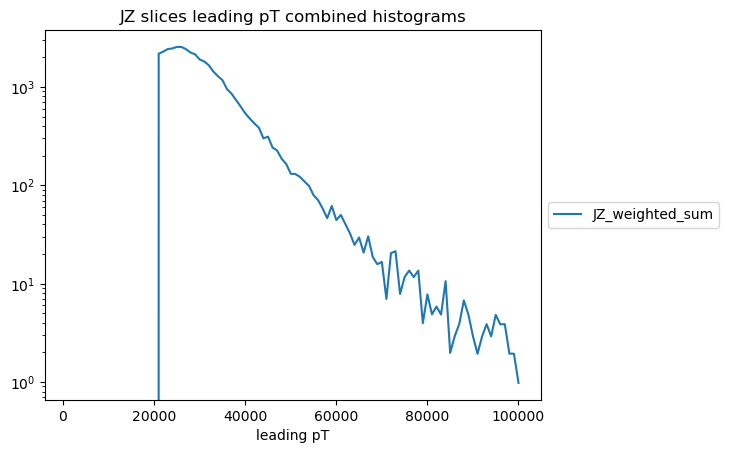

In [30]:
"""JZ slices leading pT combined histograms"""
bins = np.linspace(0, 100000, 100)

plt.plot(jz0_bin_edges[1:],leading_pT_total_hist, alpha=1, label='JZ_weighted_sum')
#plt.hist(leading_pT_jz0, bins, weights=weights_jz0, alpha=1, label='jz0_dist', histtype='stepfilled')
#plt.hist(leading_pT_jz1, bins, weights=weights_jz1, alpha=0.5, label='jz1_dist', histtype='step')
#plt.hist(leading_pT_jz2, bins, weights=weights_jz2, alpha=0.4, label='jz2_dist', histtype='step')
#plt.hist(leading_pT_jz3, bins, weights=weights_jz3, alpha=0.3, label='jz3_dist', histtype='step')
#plt.hist(leading_pT_jz4, bins, weights=weights_jz4, alpha=0.2, label='jz4_dist', histtype='step')
#plt.hist(leading_pT_jz5, bins, weights=weights_jz5, alpha=0.5, label='jz5_dist', histtype='step')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.title("JZ slices leading pT combined histograms")
plt.xlabel("leading pT")
plt.show()

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# Trial and Error

In [48]:
def get_max_log_likelihood_an_hh4b(event_id,jets,comb_num,num_highest_pt=555555):
    event_jets = jets[jets["eventNumber"] == event_id]

    if num_highest_pt != 555555:
        if len(event_jets) > num_highest_pt:
            event_jets = event_jets[(-event_jets['pt']).argsort()[:num_highest_pt]]
    
    combinations = []

    for combination in it.combinations(event_jets, comb_num):
        combinations.append(combination)

    mlpl = -999999999999
    num_bjets_chosen = 0

    for comb in combinations:
        num = 0
        denom = 0
        second_term = 0
        third_term = 0
        num_bjets = 0 
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            num += (mu) / (sigma**2)
            denom += 1 / (sigma**2)
            second_term -= np.log(sigma)
            
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            third_term -= ((num / denom) - mu)**2 / (2*sigma**2)

            if jet['HadronConeExclTruthLabelID'] == 5:
               num_bjets += 1
    
        if -4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term > mlpl:
            mlpl = -4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term
            num_bjets_chosen = num_bjets
    
    max_log_likelihood = mlpl
    
    return max_log_likelihood, num_bjets_chosen


In [49]:
%%time 
get_max_log_likelihood_an_hh4b(fom_events[11],jets,4)

ValueError: no field of name HadronConeExclTruthLabelID

In [50]:
%%time 
get_max_log_likelihood_an(fom_events[11],jets,4)

CPU times: user 3.97 ms, sys: 3.99 ms, total: 7.96 ms
Wall time: 7.97 ms


-10.85633698718557

In [26]:
def get_leading_pt_dist(string, max_num=30000):
    data = File(string, 'r')
    jets = data['jets']
    uniques = np.unique(jets["eventNumber"])
        
    counter = 0
    leading_pT = []
    
    for i in uniques:
        pTs = []
        event_jets = jets[jets["eventNumber"] == i]
        for jet in event_jets:
            pTs.append(jet["pt"])
        leading_pT.append(max(pTs))
        counter += 1
        if counter == max_num:
            break 
    return leading_pT